In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/samsung5thnov/country.xlsx
/kaggle/input/samsung5thnov/metal.xlsx
/kaggle/input/samsung5thnov/sample1.wav
/kaggle/input/samsung5thnov/jazz.xlsx
/kaggle/input/samsung5thnov/disco.xlsx
/kaggle/input/samsung5thnov/classical.xlsx
/kaggle/input/samsung5thnov/sample2.wav
/kaggle/input/samsung5thnov/reggae.xlsx
/kaggle/input/samsung5thnov/hiphop.xlsx
/kaggle/input/samsung5thnov/rock.xlsx
/kaggle/input/samsung5thnov/sample3.wav
/kaggle/input/samsung5thnov/pop.xlsx
/kaggle/input/sample4/sample4.wav


In [3]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Directory containing all your Excel files
CORPUS_XLSX_DIR = '/kaggle/input/samsung5thnov'

# Read all Excel files into one DataFrame
file_list = [f for f in os.listdir(CORPUS_XLSX_DIR) if f.endswith('.xlsx')]
print(f"Found {len(file_list)} Excel files:", file_list)

corpus_dfs = []
for fn in file_list:
    path = os.path.join(CORPUS_XLSX_DIR, fn)
    df = pd.read_excel(path)
    df['genre'] = fn.replace('.xlsx', '')
    corpus_dfs.append(df)

corpus_df = pd.concat(corpus_dfs, ignore_index=True)
print(f"Combined corpus shape: {corpus_df.shape}")
corpus_df.head()


Found 9 Excel files: ['country.xlsx', 'metal.xlsx', 'jazz.xlsx', 'disco.xlsx', 'classical.xlsx', 'reggae.xlsx', 'hiphop.xlsx', 'rock.xlsx', 'pop.xlsx']
Combined corpus shape: (166099, 8)


,start,end,pitch_midi,velocity,mask,track,genre,note_name
0,29.646637,29.798850,50,0.324670,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",country.00027.wav,country,D3
1,29.635027,29.798850,57,0.680285,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",country.00027.wav,country,A3
2,29.449267,29.635027,57,0.684424,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]",country.00027.wav,country,A3
3,29.170628,29.565367,38,0.368029,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",country.00027.wav,country,D2
4,29.135798,29.646637,50,0.374101,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",country.00027.wav,country,D3


In [7]:
# Keep only numeric columns
numeric_cols = corpus_df.select_dtypes(include='number').columns.tolist()
print("Numeric feature columns:", numeric_cols)

# Drop rows with missing values in these columns
corpus_features = corpus_df[numeric_cols].dropna()
print(f"Cleaned corpus feature shape: {corpus_features.shape}")


Numeric feature columns: ['start', 'end', 'pitch_midi', 'velocity']
Cleaned corpus feature shape: (166099, 4)


In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(corpus_features)

print("Feature matrix standardized.")


Feature matrix standardized.


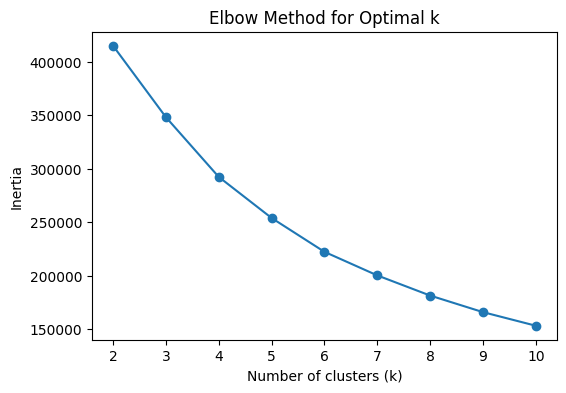

In [9]:
inertias = []
K = range(2, 11)  # Try cluster counts from 2 to 10

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled_features)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [10]:
# Choose your optimal k (based on previous plot)
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
corpus_df['cluster'] = kmeans.fit_predict(scaled_features)

print(f"Clustering complete! {optimal_k} clusters formed.")
corpus_df[['genre', 'track', 'cluster']].head()


Clustering complete! 6 clusters formed.


,genre,track,cluster
0,country,country.00027.wav,2
1,country,country.00027.wav,5
2,country,country.00027.wav,5
3,country,country.00027.wav,1
4,country,country.00027.wav,2


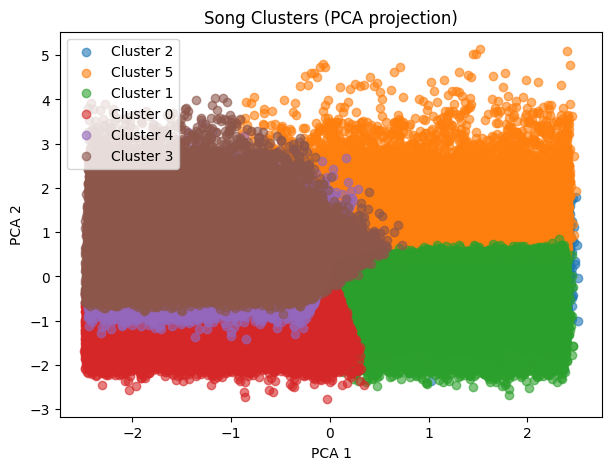

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

corpus_df['pca1'] = reduced[:, 0]
corpus_df['pca2'] = reduced[:, 1]

plt.figure(figsize=(7,5))
for c in corpus_df['cluster'].unique():
    subset = corpus_df[corpus_df['cluster'] == c]
    plt.scatter(subset['pca1'], subset['pca2'], label=f'Cluster {c}', alpha=0.6)

plt.legend()
plt.title("Song Clusters (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [13]:
!pip install basic_pitch
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.3/758.3 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.11-

In [16]:
import pretty_midi
from basic_pitch.inference import predict
import numpy as np

SAMPLE_PATH = '/kaggle/input/sample4/sample4.wav'

print("Running prediction for sample4.wav...")
out = predict(SAMPLE_PATH)
events = out[2]  # note events
df_sample = pd.DataFrame(events, columns=['start', 'end', 'pitch_midi', 'velocity', 'mask'])

# Use same numeric columns as corpus
sample_features = df_sample[numeric_cols].dropna()

# Scale using the same scaler as corpus
scaled_sample = scaler.transform(sample_features)

# Predict cluster
sample_cluster = kmeans.predict(scaled_sample)
cluster_counts = pd.Series(sample_cluster).value_counts().sort_values(ascending=False)

predicted_cluster = cluster_counts.index[0]
print(f"sample4.wav belongs mostly to Cluster: {predicted_cluster}")


Running prediction for sample4.wav...
Predicting MIDI for /kaggle/input/sample4/sample4.wav...
sample4.wav belongs mostly to Cluster: 0


In [17]:
import pretty_midi
from basic_pitch.inference import predict
import numpy as np

SAMPLE_PATH = '/kaggle/input/sample4/sample4.wav'

print("Running prediction for sample4.wav...")
out = predict(SAMPLE_PATH)
events = out[2]
df_sample = pd.DataFrame(events, columns=['start', 'end', 'pitch_midi', 'velocity', 'mask'])

# Align columns
sample_features = df_sample[numeric_cols].dropna()
scaled_sample = scaler.transform(sample_features)

# Predict cluster membership for each note, take majority
sample_cluster_predictions = kmeans.predict(scaled_sample)
predicted_cluster = pd.Series(sample_cluster_predictions).mode()[0]

print(f"sample4.wav belongs to Cluster {predicted_cluster}")


Running prediction for sample4.wav...
Predicting MIDI for /kaggle/input/sample4/sample4.wav...
sample4.wav belongs to Cluster 0
